YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


X shape: (1047, 60, 8), y shape: (1047,)
Class weights: {0: np.float64(1.059493670886076), 1: np.float64(0.9468325791855203)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │        95,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,551 (373.25 KB)

 Trainable params: 95,551 (373.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5219 - loss: 0.6984 - val_accuracy: 0.4762 - val_loss: 0.6982
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5053 - loss: 0.6927 - val_accuracy: 0.4762 - val_loss: 0.6996
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5077 - loss: 0.6925 - val_accuracy: 0.4762 - val_loss: 0.7002
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5004 - loss: 0.6923 - val_accuracy: 0.4762 - val_loss: 0.7007
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5020 - loss: 0.6922 - val_accuracy: 0.4762 - val_loss: 0.7011
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5045 - loss: 0.6921 - val_accuracy: 0.4762 - val_loss: 0.7015
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5017 - loss: 0.6920 - val_accuracy: 0.4762 - val_loss: 0.7018
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5010 - loss: 0.6920 - val_accuracy: 0.4762 - va

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

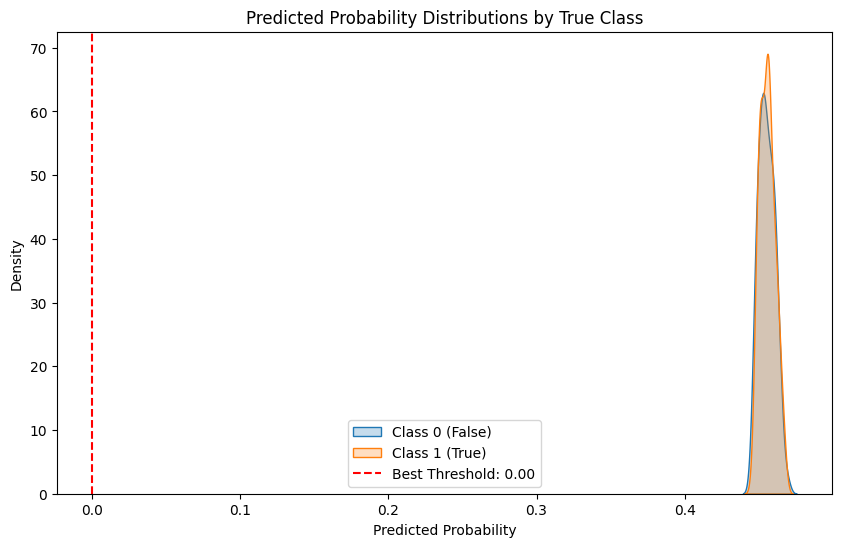

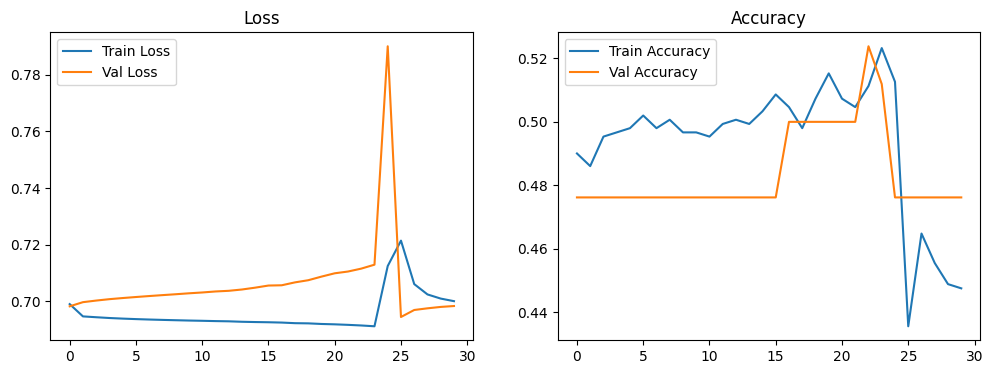

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Adam

# --- Data download and feature engineering ---
data = yf.download(tickers='^NDX', start='2020-06-01', end='2025-06-01')
data.columns = [col[0] for col in data.columns]

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Adj Close'] = data['Close']

# Classification target: TargetClass = 1 if next day Adj Close > Open else 0
data['Target'] = (data['Adj Close'] - data['Open']).shift(-1)
data['TargetClass'] = (data['Target'] > 0).astype(int)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)

# --- Prepare features ---
feature_columns = ['High', 'Low', 'Open', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
backcandles = 60

# Create sequences of features
X = []
for j in range(len(feature_columns)):
    X.append([data[feature_columns[j]].iloc[i-backcandles:i].values for i in range(backcandles, len(data))])

X = np.moveaxis(X, 0, 2)  # shape: (samples, backcandles, features)
y = data['TargetClass'].values[backcandles:]

print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- Scale features ---
scaler_X = MinMaxScaler()
n_samples, n_timesteps, n_features = X.shape
X_2d = X.reshape(-1, n_features)
X_scaled_2d = scaler_X.fit_transform(X_2d)
X_scaled = X_scaled_2d.reshape(n_samples, n_timesteps, n_features)

# --- Train-test split ---
split_idx = int(0.8 * n_samples)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Compute class weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# --- Build LSTM classification model ---
tf.random.set_seed(42)
input_layer = Input(shape=(backcandles, len(feature_columns)))
x = LSTM(150)(input_layer)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- Train model with class weights ---
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=15,
    validation_split=0.1,
    shuffle=True,
    class_weight=class_weight_dict
)

# --- Predict probabilities ---
y_pred_prob = model.predict(X_test).flatten()

# --- Find best threshold by F1 score ---
thresholds = np.linspace(0, 1, 101)
f1_scores = []
for thresh in thresholds:
    preds = (y_pred_prob >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold by F1: {best_thresh:.2f} with F1: {best_f1:.3f}")

# --- Final predictions at best threshold ---
y_pred_final = (y_pred_prob >= best_thresh).astype(int)

# --- Classification report ---
print("--- LSTM Classification Report ---")
print(classification_report(y_test, y_pred_final))
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# --- Precision-Recall AUC ---
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

# --- Plot predicted probability distributions by true class ---
plt.figure(figsize=(10,6))
sns.kdeplot(y_pred_prob[y_test == 0], label='Class 0 (False)', shade=True)
sns.kdeplot(y_pred_prob[y_test == 1], label='Class 1 (True)', shade=True)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold: {best_thresh:.2f}')
plt.title('Predicted Probability Distributions by True Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

# --- Plot training history ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


In [2]:
from keras.layers import Bidirectional, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build improved model
input_layer = Input(shape=(backcandles, len(feature_columns)))
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(input_layer)
x = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=5e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5321 - loss: 0.6915 - val_accuracy: 0.4762 - val_loss: 0.7066 - learning_rate: 5.0000e-04
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4700 - loss: 0.6949 - val_accuracy: 0.4762 - val_loss: 0.6975 - learning_rate: 5.0000e-04
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5091 - loss: 0.6918 - val_accuracy: 0.4762 - val_loss: 0.6994 - learning_rate: 5.0000e-04
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5242 - loss: 0.6906 - val_accuracy: 0.4762 - val_loss: 0.6992 - learning_rate: 5.0000e-04
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5129 - loss: 0.6922 - val_accuracy: 0.4762 - val_loss: 0.6988 - learning_rate: 5.0000e-04
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5143 - loss: 0.6919 - val_accuracy: 0.4762 - val_loss: 0.7021 - learning_rate: 5.0000e-04
Epoch 7/80
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5117 